# Relationship Between IAQ and Mood
More of a causal relationship, we look at identifying a link between IAQ and mood.

In [31]:
import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Home Pollutant Exposures and Mood
The purpose of this notebook is to look at the in-depth relationships between IAQ and mood, some of which has already been conducted but refractored to this notebook and, more formally, in a script within `src/analysis/iaq_and_mood`

In [32]:
import os
import sys
sys.path.append('../')

from src.visualization import visualize
from src.analysis import iaq_and_mood

import pandas as pd
pd.set_option('display.max_columns', 200)
import numpy as np

import math
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns

---

<a id="toc"></a>

# Table of Contents
1. [Notes on Analyses](#analyses_notes)
2. [Notes on Data Used](#data_notes)
3. [Confounding Variable(s) Analysis](#confounding)
4. [Available Data](#data_availability)
5. [Home IAQ Exposure and Mood](#home_exposure)
    1. Summary
    2. [Factor Analysis](#fb_factor_analysis)
    3. [Main Analysis](#fb_analysis)
6. [Ventilation](#fb_and_ventilation)
    1. [Sleep Quality for Adequate/Inadequate Ventilation](#fb_sleep_distributions_and_ventilation)
    2. [Ventilation During Poor/Satisfactory Sleep Quality](#fb_ventilation_distributions_and_sleep)
    5. [Binary Relationship](#fb_sleep_and_ventilation_bi)
7. [IAQ and Self-Reported Sleep Quality](#ema)
    1. Pre-Processing
    2. Summary
    3. [Factor Analysis](#bw_factor_analysis)
    3. [Main Analysis](#ema_sleep_and_iaq_analysis)
8. [Ventilation](#bw_and_ventilation)
    1. [Sleep Quality for Adequate/Inadequate Ventilation](#bw_sleep_distributions_and_ventilation)
    2. [Ventilation During Poor/Satisfactory Sleep Quality](#bw_ventilation_distributions_and_sleep)

---

<a id="analyses_notes"></a>

[Back to ToC](#toc)
# Notes on the Analyses
This notebook contains multiple analysis aimed at determining the extent that IAQ might affect mood. These are outlined below.

## Home IAQ Exposure Prior to Submitting EMA
We look at what how exposure to IAQ at home prior to submitting an EMA affects the outcome. There are some caveats to this that we should consider:

1. **Length of Time at Home**: This variable could have a variety of effects including:
    1. **Participant acclimates to environment**: At a certain point, the participant would likely get used to their environment thus diminishing the effect of IAQ on the mood response.
    2. **Cumulative exposure**: Perhaps we should derive a metric that takes into account the concentration over the period of time. Something like the cumulative concentration or perhaps the time of exposure multiplied by the median/mean concentration during that period?
2. **Summary Statistic**: Which statistic/metric is appropriate? Mean? Median? Max? 90th-percentile?
3. **Sensitivity to IAQ Parameters**: Is CO2 more important than CO for mood? Should we control for other parameters? Is there an association between parameters to even control for? Perhaps a neat way to get around this is to derive some sort of air quality index even if it is simply a sum of the binary outcomes of whether or not pollutants are above or below certain thresholds outlined below:
    * **TVOCs**: The "short and long-term" [recommendation by the WHO](https://iaqscience.lbl.gov/voc-intro) is 100 ppb, but we double this value since the TVOC measurements we make are higher. Therefore, `tvoc_threshold=200`.
    * **CO**: The WHO published a [study on CO guidelines](https://www.ncbi.nlm.nih.gov/books/NBK138710/) and recommended as low as 7 mg/m$^3$ which is approximately 6 ppm. The mean concentration from our filed study is approximately 4 pp, so we use this value i.e. `co_threshold=4`.
    * **CO$_2$**: [OSHA](https://ohsonline.com/Articles/2016/04/01/Carbon-Dioxide-Detection-and-Indoor-Air-Quality-Control.aspx?m=1&Page=2) and ASHRAE generally agree that concentrations above 1100 ppm tend to create some issues therefore `co2_threshold=1100`.
    * **PM2.5** (mass): Considering the EPA again, the outdoor annual exposure limit is 12 $\mu$g/m$^3$ and the [EPA mentions](https://www.epa.gov/indoor-air-quality-iaq/indoor-particulate-matter#Levels_in_Homes) that concentrations indoors would mirror outdoor concentrations absent of any indoor sources. We considered using half this concentration, but indoor measurements were high enough to consider the EPA's outdoor exposure limit therefore `pm2p5_mass_threshold=12`.
    * **Temperature**: The ideal temperature range is between 60-67F which is lower than the minimum temperature that was measured. So we opt for the mean concentration measured during the sleep events: `temperature_c_threshold=25.2`.

## Exposure to Extreme IAQ Events and Mood
Just like the analysis with sleep: small pertubations in the IAQ parameters might not manifest in any noticeable changes to mood. Therefore, we should examine the extreme events where we define _extreme_ as some number of standard deviations above or below the mean. 

## Limitations
The primary limitations to this work include:

1. **Causal Relationship**: Pinpointing the exact nature of the relationship is tricky because _so_ many variables can affect mood. While we try to control for a few of these variables, controlling for all of them is a bit tricky.
2. **Mood Score**: With only a narrow band of mood scores (0-3 integer scale), there are limits to the statistical analysis that we can perform.

---

<a id="data_notes"></a>

[Back to ToC](#toc)
# Notes on the Data Used in these Analyses
For the analyses conducted in this notebook we need:

---

<a id="confounding"></a>

[Back to ToC](#toc)
# Exploring Datasets: Confounding Variables
There are quite a few confounding variables that might contribute to a participant's response which might not be linked to their IAQ. We want to analyze these to see how strong these associations are. Some of the more obvious associations include:
* [Time at Home](#time_at_home): Participants might acclimate to their environment or have a more pronounced response if their IAQ is "fresh" on their mind.
* [Day of the Week](#dow): Participants are likely to rate moods like `discontent` lower on the weekend versus the weekday.
* [Mood on Mood](#mood_on_mood): Some moods have a natural association so perhaps the response on one mood affects the other. 
* [Previous Mood](#previous_mood): Perhaps a participant's previous mood response is correlated to their response at the end of the day.

In [40]:
confounding_check = iaq_and_mood.Explore()
confounding_check.process(scale=True)

<a id="time_at_home"></a>

## Dependency of Mood Scores on Length of Time at Home
Before looking into Mood and IAQ, perhaps we look into a confounder: whether the length a participant is at home affects their response.

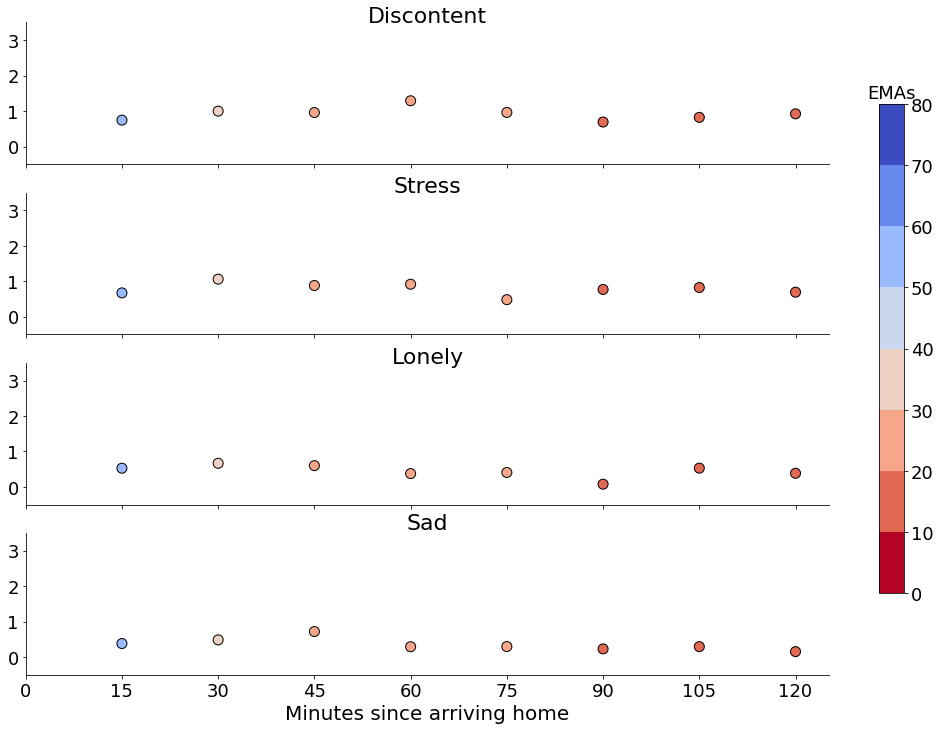

In [34]:
confounding_check.plot_mood_on_time(interval=15,max_t=120)

<a id="dow"></a>

In [105]:
confounding_check.categorize_time_at_home()

In [107]:
moods=["discontent","sad","lonely","stress"]
for mood in moods:
    confounding_check.conduct_mood_anova(mood,"minutes_at_home_cat")

DISCONTENT
ANOVA p-value: 0.974
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
  <120   <180   0.0661   0.9 -0.3854 0.5175  False
  <120   <240   0.0619   0.9 -0.4368 0.5607  False
  <120   <300   0.0403   0.9 -0.5053  0.586  False
  <120   <360  -0.0479   0.9 -0.5935 0.4978  False
  <120    <60   0.0702   0.9 -0.3133 0.4537  False
  <120   >360   0.0874   0.9 -0.2487 0.4234  False
  <180   <240  -0.0042   0.9  -0.512 0.5036  False
  <180   <300  -0.0257   0.9 -0.5797 0.5282  False
  <180   <360   -0.114   0.9 -0.6679   0.44  False
  <180    <60   0.0041   0.9 -0.3911 0.3993  False
  <180   >360   0.0213   0.9 -0.3281 0.3707  False
  <240   <300  -0.0216   0.9 -0.6147 0.5716  False
  <240   <360  -0.1098   0.9 -0.7029 0.4833  False
  <240    <60   0.0083   0.9 -0.4402 0.4568  False
  <240   >360   0.0255   0.9 -0.3832 0.4341  False
  <300   <360  -0.0882   0.9 -0.7213 0.5448  Fals

## Dependency of Mood Scores on Day of Week
Likely a factor in moods like ``discontent`` and ``stress``.

Some helpful resources:
* [Day of Week from Datetime](https://www.delftstack.com/howto/python/python-datetime-day-of-week/)
* [Datetime Reference](https://docs.python.org/3/library/datetime.html)
* [Re-ordering Pandas Index](https://stackoverflow.com/questions/30212214/pandas-series-change-order-of-index)

### Visualize Mean Aggregated Responses Across DoW
We start by visualizing the mood scores on each day of the week. 

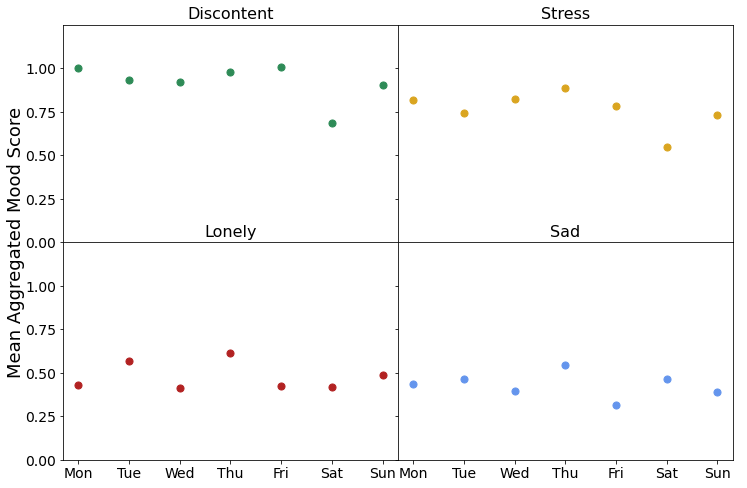

In [35]:
ema_dow = confounding_check.plot_mood_on_dow(scale=False)

<div class="alert alert-block alert-warning">
 
Responses to `discontent` and `stress` _appear_ to be lower on Saturdays relative to the other DoWs.
    
</div>

### ANOVA on Mean Aggregated Responses by DoW
Now we use ANOVA to see if there are any statistically signficant differences across DoW.

Some helpful resources:
* [StatQuest on ANOVA](https://www.youtube.com/watch?v=NF5_btOaCig)
* [TDS Article on ANOVA in Python](https://towardsdatascience.com/anova-test-with-python-cfbf4013328b)
* [Blog Post about ANOVA in Python](https://www.reneshbedre.com/blog/anova.html)
* [TDS Article with ANOVA + Tukey in Python](https://towardsdatascience.com/anova-tukey-test-in-python-b3082b6e6bda)
* [`scipy.stats.f_oneway`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html)
* [Tukey HSD in `statsmodels`](https://www.statsmodels.org/dev/generated/statsmodels.stats.multicomp.pairwise_tukeyhsd.html)
* [Unpacking lists in Python](https://thispointer.com/python-how-to-unpack-list-tuple-or-dictionary-to-function-arguments-using/)

In [36]:
moods=["discontent","sad","lonely","stress"]
for mood in moods:
    confounding_check.conduct_mood_anova(mood,"DoW")

DISCONTENT
ANOVA p-value: 0.298
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   Fri    Mon  -0.0074    0.9 -0.2961 0.2814  False
   Fri    Sat   -0.324   0.21 -0.7271  0.079  False
   Fri    Sun  -0.1039    0.9 -0.4009  0.193  False
   Fri    Thu  -0.0301    0.9 -0.4811  0.421  False
   Fri    Tue  -0.0763    0.9 -0.4842 0.3315  False
   Fri    Wed  -0.0827    0.9 -0.3926 0.2272  False
   Mon    Sat  -0.3167 0.1806 -0.6993 0.0659  False
   Mon    Sun  -0.0966    0.9 -0.3651 0.1719  False
   Mon    Thu  -0.0227    0.9 -0.4556 0.4101  False
   Mon    Tue   -0.069    0.9 -0.4566 0.3187  False
   Mon    Wed  -0.0753    0.9 -0.3581 0.2075  False
   Sat    Sun   0.2201 0.6159 -0.1687 0.6089  False
   Sat    Thu   0.2939   0.61 -0.2222 0.8101  False
   Sat    Tue   0.2477 0.7005 -0.2312 0.7266  False
   Sat    Wed   0.2413 0.5482 -0.1575 0.6401  False
   Sun    Thu   0.0739    0.9 -0

<div class="alert alert-block alert-success">
 
There are **no** statistically significant differences between the mood scores reported on different days of the week according to the aggregated data. 
    
</div>

<a id="mood_on_mood"></a>

## Correlations Between Mood Responses
There are likely correlations between resposnes so we look at that in more depth.

We will be using [Cramer's V]() to determine if there are correlations between each pair of mood responses since there doesn't seem to be an easily explanable method that compares all at the same time.

### Discrete
Keeping all 4 possible responses.

In [37]:
mood_corr_discrete = confounding_check.determine_mood_associations()
mood_corr_discrete

,mood1,mood2,score
0,discontent,stress,0.424268
1,discontent,lonely,0.328427
2,discontent,sad,0.401114
3,stress,discontent,0.424268
4,stress,lonely,0.283119
5,stress,sad,0.358936
6,lonely,discontent,0.328427
7,lonely,stress,0.283119
8,lonely,sad,0.432354
9,sad,discontent,0.401114


### Binary
Simplifying the problem by looking at the binary responses now.

In [41]:
mood_corr_binary = confounding_check.determine_mood_associations(binary=True)
mood_corr_binary

,mood1,mood2,score
0,discontent,stress,0.345935
1,discontent,lonely,0.288097
2,discontent,sad,0.339763
3,stress,discontent,0.345935
4,stress,lonely,0.278993
5,stress,sad,0.303770
6,lonely,discontent,0.288097
7,lonely,stress,0.278993
8,lonely,sad,0.553612
9,sad,discontent,0.339763


<div class="alert alert-block alert-success">
 
Even when represented as binary values, the associations between the responses are still below 0.55 which indicates only a _weak_ relationship is present.  
    
</div>

<a id="previous_mood"></a>

## Dependency of Previous Mood on Evening Mood
We can only consider EMAs from participants that were filled out on the same day where the second EMA was completed shortly after arriving home. 

In [42]:
ema_morning_and_evening_home = confounding_check.ema_all.merge(confounding_check.ema,left_on=["timestamp_evening"],right_index=True)
diff_res = {mood: [] for mood in ["content","sad","stress","lonely"]}
for mood in ["content","sad","stress","lonely"]:
    diff_res[mood] = (abs(ema_morning_and_evening_home[f"{mood}_morning"] - ema_morning_and_evening_home[f"{mood}_evening"]).values)
    
pd.DataFrame(diff_res)

,content,sad,stress,lonely
0,0.0,1.0,0.0,1.0
1,1.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0
5,0.0,2.0,1.0,0.0
6,1.0,0.0,0.0,NaN


<div class="alert alert-block alert-warning">
 
With only 7 observations, we cannot say much about the morning mood affecting the evening mood's responses although at least all 7 observations don't have a difference of 0. However, even if they did, the relatively small scale already forces these differences to be small. 
    
</div>

---

<a id="data_availability"></a>

[Back to ToC](#toc)
# Available Data

summary object

In [51]:
summary = iaq_and_mood.Explore()
summary.process(scale=True)

getting Beiwe IDs for participants who had beacons

In [55]:
bb_ids = summary.iaq["beiwe"].unique()

## EMAs

### Available Morning EMAs

In [56]:
morning_ema = pd.read_csv("../data/processed/beiwe-morning_ema-ux_s20.csv")
print("Raw Morning N:", len(morning_ema))
morning_ema_with_bb = morning_ema[morning_ema["beiwe"].isin(bb_ids)]
print("Morning EMA and BB:", len(morning_ema_with_bb))
print("Number of Participants:",len(morning_ema_with_bb["beiwe"].unique()))

Raw Morning N: 2470
Morning EMA and BB: 1210
Number of Participants: 24


Available Evening EMAs

In [57]:
evening_ema = pd.read_csv("../data/processed/beiwe-evening_ema-ux_s20.csv")
print("Raw Evening N:", len(evening_ema))
evening_ema_with_bb = evening_ema[evening_ema["beiwe"].isin(bb_ids)]
print("Evening EMA and BB:",len(evening_ema_with_bb))
print("Number of Participants:",len(evening_ema_with_bb["beiwe"].unique()))

Raw Evening N: 2460
Evening EMA and BB: 1196
Number of Participants: 24


### Mood Responses

#### Discrete, Unaltered

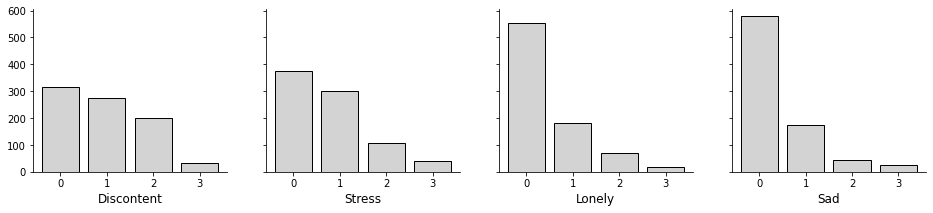

In [58]:
mood_distribution_discrete = summary.get_mood_distribution(plot=True,binary=False)

#### Binary

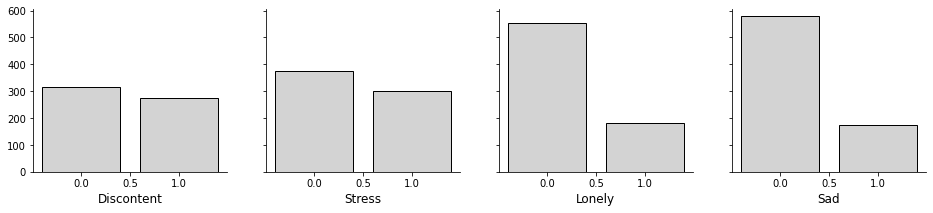

In [59]:
mood_distribution_discrete = summary.get_mood_distribution(plot=True,binary=True)

[Back to Data Availability](#data_availability)

---

<a id="home_exposure"></a>

[Back to ToC](#toc)
# Home IAQ Exposure and Mood
Mood responses due to IAQ exposure. The following cells take a look a few sub-analysis:
1. [Pollutant Exposure for Binary Mood](#home_exposure_pollutant_distribution): A look at the causal relationship between the IAQ prior to submitting EMAs at home.
    1. Pollutant Correlation
    2. By Pollutant
    3. Aggregate Pollutant
    4. Ventilation as a Proxy 
2. [Mood Changes for Binary IAQ](#home_exposure_mood_changes_all): How mood differs when IAQ parameters are satisfactory or poor.
3. [Exposure Period and Mood Changes](#home_exposure_mood_changes_periods): Does mood change between short and longer exposure periods?

There are a lot of options to toggle here:
* **Exposure Period Length**: What happens when consider periods of being home < 30 minutes vs < 60 minutes, etc.?
* **Summary Statistic for Exposure Period**: Mentioned earlier, but how do we summarize the IAQ parameter during the exposure period? Mean or median seems natural, but the max concentration could be more illuminating perhaps?
* **Binarizing Scheme**: For moods, we might consider a different binarizing scheme especially for moods like `lonely` that very rarely see responses above 0. For IAQ, the story becomes even more complicated: do we use "established" thresholds or participant-specific thresholds? If the latter, how do we properly define these because we again have the trouble of determining which is the best summary statistic but also do we consider _all_ IAQ measurements during the study? Or just those from exposure periods that we identify?

<div class="alert alert-block alert-warning">
 
Need to consider some level of sensitivity analysis based on the discussion in the previous cell.
    
</div>

In [96]:
home_exposure = iaq_and_mood.Analyze()
home_exposure.process(scale=False)

The default is to include:
* **Exposure Period Length**: entire time at home prior to submission i.e. ``window=True``
* **IAQ Binarizing Scheme**: thresholds determined from the literature applied across all participants i.e. ``thresholds=None``

In [97]:
home_exposure.summarize_iaq_before_submission(window=15)
home_exposure.binarize_iaq()

<div class="alert alert-block alert-warning">
 
There is really no good way to assess the "acclimation to home environment" variable but rather we should consider shorter exposure periods prior to submission _rather_ than that entire period of being home i.e. **``window=True`` is bad**. Participants could have been home for hours, but we only consider the IAQ during a subset of that time since that would _more likely_ manifest in a mood change versus some IAQ event that happened at the beginning of the participant's time at home that they might have forgotten by the time the EMA is completed.
    
</div>

<a id="home_exposure_pollutant_distribution"></a>

## Mean Pollutant Concentrations for Binary Mood Responses
This analysis is focused on determining if there are significant differences in pollutant concentrations for periods prior to submission where the mood response is good or bad. 

### Pollutant Correlation
We might not need to look at all the IAQ data since some of the pollutant profiles might be correlated.

#### Correlation Matrix
The simplest and quickest way to determine if there is a significant association.

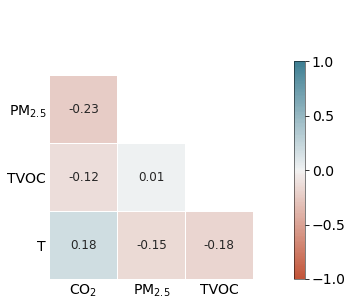

In [17]:
home_exposure.plot_correlation_matrix()

#### Factor Analysis
Something else to consider, but not currently conducted due to time constraints. 

### By Pollutant
Analysis separated out by each pollutant.

#### Summarized Pollutants from Period Prior to EMA Submission
We look at the _summarized_ pollutant concentrations prior to EMA submission for binary EMA responses that are `low` or `high`. Then we conduct a t-Test between the distributions to see if the difference in means is _statistically significant_. 

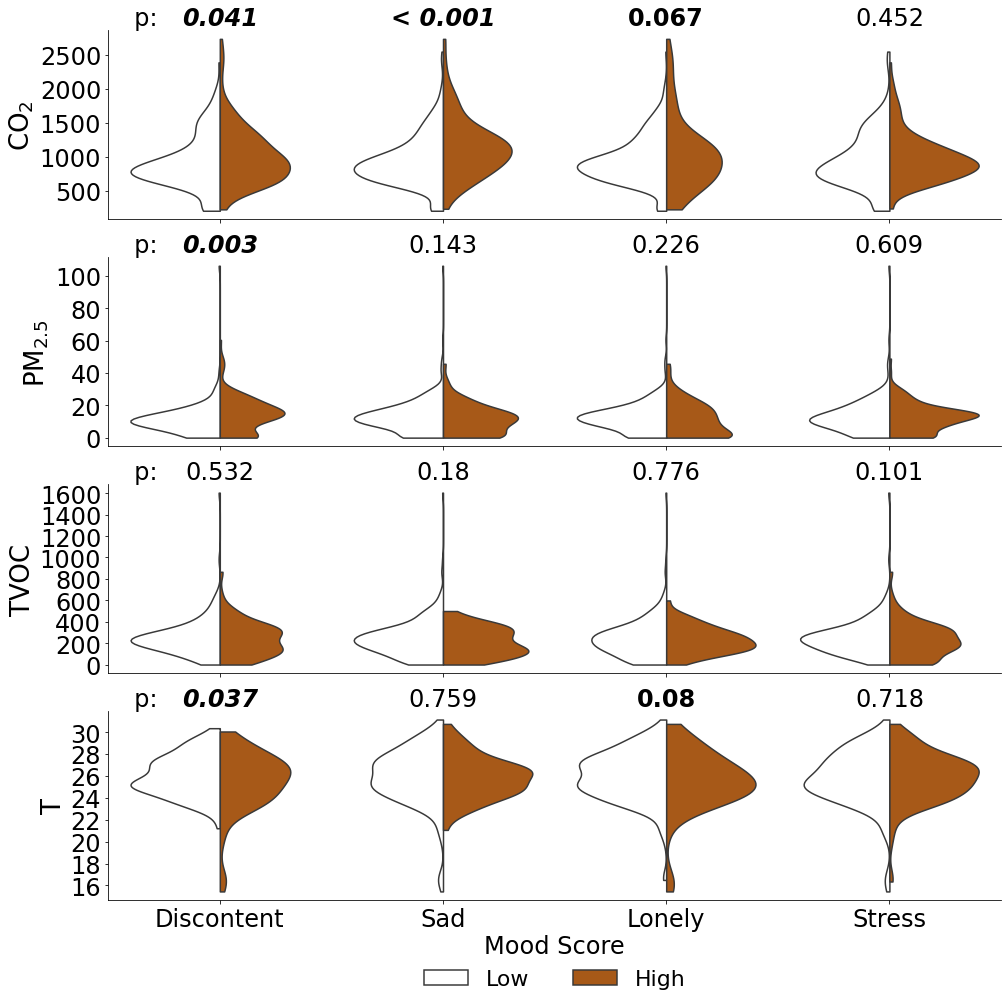

{'co2':             low  high    mean_low    mean_high         p
 mood                                                    
 Discontent  139   126  923.587667  1031.600836  0.040974
 Sad         278    71  943.951478  1155.297994  0.000078
 Lonely      274    65  957.482758  1059.810132  0.066868
 Stress      166   142  947.774674   981.981079  0.452306,
 'pm2p5_mass':             low  high   mean_low  mean_high         p
 mood                                                 
 Discontent  139   126  11.643379  15.672975  0.002899
 Sad         278    71  13.782315  11.741393  0.142679
 Lonely      274    65  13.427168  11.672189  0.225991
 Stress      166   142  13.761771  13.145572  0.608987,
 'tvoc':             low  high    mean_low   mean_high         p
 mood                                                   
 Discontent  139   126  260.337593  246.595474  0.532479
 Sad         278    71  242.514978  211.939948  0.180174
 Lonely      274    65  240.390102  233.593589  0.776080
 Stres

In [18]:
home_exposure.plot_mood_violin_per_iaq(moods=["discontent","sad","lonely","stress"])

<div class="alert alert-block alert-success">
 
There are quite a few relationships that are statistically significant however this might change depending on the toggles mentioned at the [beginning](#home_exposure) of this analysis.
    
</div>

### Aggregate Pollutant Metric
While developing an AQI seems like the best route, it also is outside the scope of this analysis and is probably just as "hand-wavy" as what I propose. However, from a quick search, there appear to be a few entities that have already developed an AQI for all the parameters that I am considering. So we can borrow from them to develop two aggregate measures of IAQ:

1. **AQI**: Borrowing CO2, T/RH, and TVOC indices from [Breeze]() in conjunction with a PM2.5 index from [AirNow]() we can create an overall AQI by determining the contribution from each parameter.
2. **Sum of Binary IAQ**: Same idea as above, but we simply sum the binary IAQ metric from each pollutant. 

#### Aggregate AQI

In [21]:
home_exposure.get_aggregate_aqi(use_binary=False)
# home_exposure.get_na()

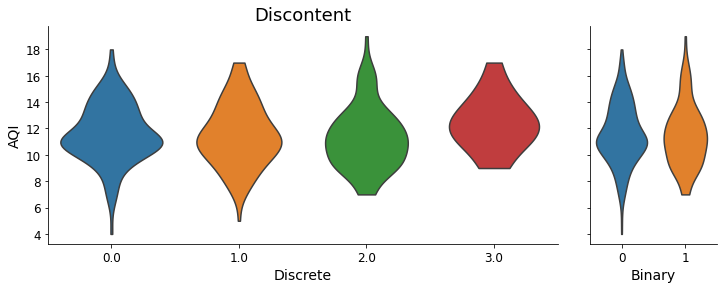

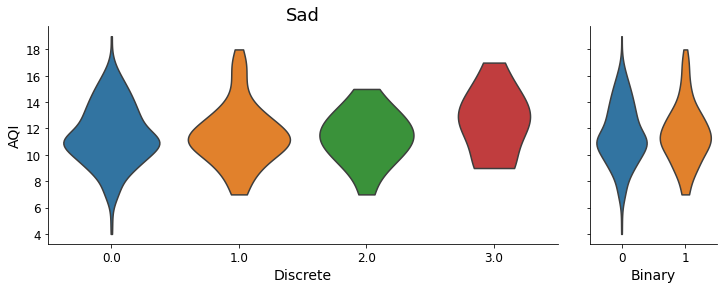

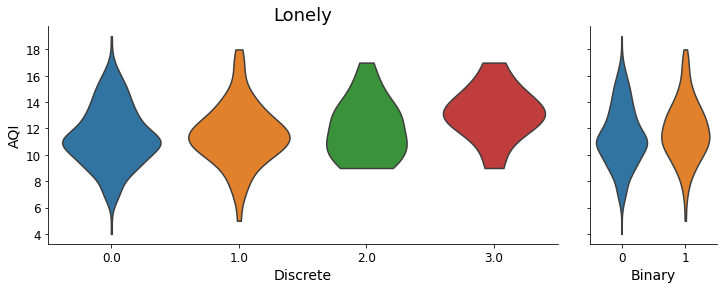

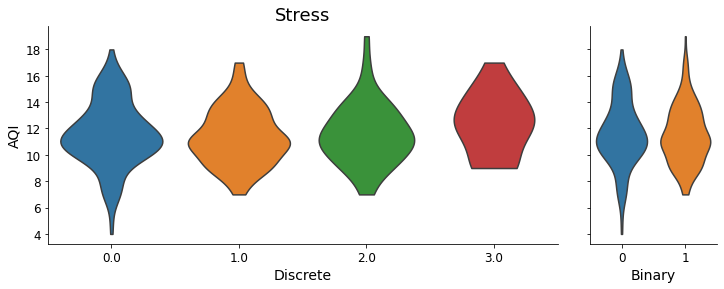

In [22]:
for mood in ["discontent","sad","lonely","stress"]:
    home_exposure.plot_aqi_vs_mood(mood=mood)

### Ventilation as a Proxy for IAQ
While the analysis above was interesting, there is a third option we can use to get to an overall estimate of IAQ and that is ventilation. The only issue with this method is we have to look at the participant's responses over the entire study period rather than each exposure period because we cannot _accurately_ estimate ventilation in the home of the participant -- only the bedroom (which has issues of its own). 

<a id="home_exposure_mood_changes_all"></a>

## Changes in Mood for Binary IAQ
A reversal of the analysis we previously conducted where we look at the raw mood scores and how they change based on poor or satisfactory IAQ.

How we determine poor IAQ can vary:
1. **Standard Thresholds**: Values specified by various organizations
2. **Summary Stat**: One of ["mean","median"]

How we determine changes in mood can also vary:
1. **Mean Responses**: Simply look at the mean response for periods with poor or satisfactory mood
2. **Changes from Overall Mean Mood Score**: Likely a better approach, we look at the change in participant responses from their overall mean for these IAQ periods.
    * Negative Mood Differences: _worse_ mood scores since they would be _below_ the mean
    * Positive Mood Differences: _improved_ mood scores since they would be _above_ the mean

### Standard
We start by looking at the mood responses per individual under poor and satisfactory IAQ conditions.

### Standard, Mean Response

In [197]:
for param in ["co2","pm2p5_mass","tvoc","temperature_c"]:
    print(param.upper(),"\n")
    res = home_exposure.compare_mean_mood_scores(ieq_param=param)
    print(res.to_latex())

CO2 

High: 	269
Low:	117
\begin{tabular}{lrrl}
\toprule
{} &  mean\_low &  mean\_high &        p \\
\midrule
Discontent &      1.11 &       0.98 &  0.087** \\
Stress     &      0.93 &       0.76 &   0.043* \\
Sad        &      0.54 &       0.33 &   0.002* \\
Lonely     &      0.57 &       0.35 &   0.007* \\
Energy     &      1.93 &       2.16 &   0.033* \\
\bottomrule
\end{tabular}

PM2P5_MASS 

High: 	204
Low:	192
\begin{tabular}{lrrl}
\toprule
{} &  mean\_low &  mean\_high &        p \\
\midrule
Discontent &      1.06 &       0.91 &   0.014* \\
Stress     &      0.82 &       0.75 &  0.092** \\
Sad        &      0.34 &       0.41 &    0.107 \\
Lonely     &      0.42 &       0.39 &     0.43 \\
Energy     &      2.22 &       1.99 &   0.007* \\
\bottomrule
\end{tabular}

TVOC 

High: 	187
Low:	215
\begin{tabular}{lrrl}
\toprule
{} &  mean\_low &  mean\_high &        p \\
\midrule
Discontent &      0.92 &       1.07 &   0.022* \\
Stress     &      0.68 &       0.91 &   0.002* \\
Sad     

### Standard, Mood Difference

In [90]:
#home_exposure.binarize_iaq(thresholds=None,comparator="median")
for param in ["co2","pm2p5_mass","tvoc","temperature_c"]:
    print(param.upper(),"\n")
    res = home_exposure.compare_mood_scores(ieq_param=param,summarize_mood="diff")
    print(res.to_latex())

CO2 

High: 	269
Low:	117
\begin{tabular}{llll}
\toprule
{} &   mean\_low &  mean\_high &      p \\
\midrule
Discontent &   0.09 (0) &    0.0 (0) &  0.443 \\
Stress     &   0.15 (0) &   -0.0 (0) &  0.307 \\
Sad        &  -0.03 (0) &  -0.02 (0) &  0.296 \\
Lonely     &  -0.02 (0) &  -0.01 (0) &  0.385 \\
Energy     &  -0.08 (0) &  -0.05 (0) &  0.386 \\
\bottomrule
\end{tabular}

PM2P5_MASS 

High: 	204
Low:	192
\begin{tabular}{llll}
\toprule
{} &   mean\_low &  mean\_high &        p \\
\midrule
Discontent &   0.01 (0) &  -0.04 (0) &    0.149 \\
Stress     &   0.09 (0) &  -0.12 (0) &  0.063** \\
Sad        &   0.02 (0) &  -0.01 (0) &  0.096** \\
Lonely     &   0.07 (0) &  -0.08 (0) &    0.153 \\
Energy     &  -0.05 (0) &    0.0 (0) &    0.473 \\
\bottomrule
\end{tabular}

TVOC 

High: 	187
Low:	215
\begin{tabular}{llll}
\toprule
{} &   mean\_low &  mean\_high &       p \\
\midrule
Discontent &  -0.03 (0) &  -0.01 (0) &   0.155 \\
Stress     &  -0.04 (0) &   0.03 (0) &  0.026* \\
Sad     

### Median, Mood Mean

In [99]:
home_exposure.binarize_iaq(thresholds="median",comparator="median")
for param in ["co2","pm2p5_mass","tvoc","temperature_c"]:
    print(param.upper(),"\n")
    res = home_exposure.compare_mood_scores(ieq_param=param)
    print(res.to_latex())

CO2 

High: 	218
Low:	168
\begin{tabular}{llll}
\toprule
{} &     mean\_low &    mean\_high &        p \\
\midrule
Discontent &  1.09 (0.88) &  0.97 (0.88) &   0.09** \\
Stress     &  0.82 (0.83) &  0.81 (0.86) &    0.394 \\
Sad        &  0.46 (0.78) &   0.35 (0.7) &  0.056** \\
Lonely     &  0.44 (0.75) &   0.4 (0.77) &    0.126 \\
Energy     &  2.08 (1.05) &   2.1 (1.05) &    0.418 \\
\bottomrule
\end{tabular}

PM2P5_MASS 

High: 	184
Low:	212
\begin{tabular}{llll}
\toprule
{} &     mean\_low &    mean\_high &      p \\
\midrule
Discontent &   1.0 (0.89) &  0.95 (0.89) &   0.29 \\
Stress     &  0.83 (0.85) &  0.73 (0.83) &  0.108 \\
Sad        &  0.42 (0.76) &  0.32 (0.65) &  0.114 \\
Lonely     &   0.44 (0.8) &  0.36 (0.69) &  0.278 \\
Energy     &  2.09 (1.08) &   2.1 (0.99) &  0.489 \\
\bottomrule
\end{tabular}

TVOC 

High: 	224
Low:	178
\begin{tabular}{llll}
\toprule
{} &     mean\_low &    mean\_high &        p \\
\midrule
Discontent &  0.91 (0.88) &  1.05 (0.88) &  0.052** \\


### Median, Mood Difference

In [102]:
home_exposure.binarize_iaq(thresholds="median",comparator="median")
for param in ["co2","pm2p5_mass","tvoc","temperature_c"]:
    print(param.upper(),"\n")
    res = home_exposure.compare_difference_mood_scores(ieq_param=param)
    print(res.to_latex())

CO2 

High: 	218
Low:	168
\begin{tabular}{lrrl}
\toprule
{} &  mean\_low &  mean\_high &      p \\
\midrule
Discontent &     -0.01 &      -0.01 &  0.223 \\
Stress     &     -0.02 &      -0.00 &  0.405 \\
Sad        &     -0.01 &      -0.02 &  0.261 \\
Lonely     &     -0.01 &      -0.01 &  0.332 \\
Energy     &     -0.02 &       0.01 &  0.453 \\
\bottomrule
\end{tabular}

PM2P5_MASS 

High: 	184
Low:	212
\begin{tabular}{lrrl}
\toprule
{} &  mean\_low &  mean\_high &       p \\
\midrule
Discontent &     -0.02 &       0.01 &   0.488 \\
Stress     &     -0.01 &      -0.03 &   0.133 \\
Sad        &     -0.02 &      -0.06 &  0.034* \\
Lonely     &     -0.02 &      -0.04 &  0.09** \\
Energy     &      0.06 &      -0.05 &   0.471 \\
\bottomrule
\end{tabular}

TVOC 

High: 	224
Low:	178
\begin{tabular}{lrrl}
\toprule
{} &  mean\_low &  mean\_high &      p \\
\midrule
Discontent &     -0.04 &       0.03 &  0.112 \\
Stress     &      0.01 &      -0.02 &  0.368 \\
Sad        &      0.01 &      -0

[Back to Home Exposure and Mood](#home_exposure)

---